
**Complete Pipeline for Quantile-Based Catchment Analysis**
**Compares d-HyMoLAP vs HyMoLAP models on CAMELS-FR and CAMELS-GB datasets**

**Author:** Lionel Cedric Gohouede


In [ ]:
pip install aqua-fetch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from aqua_fetch import RainfallRunoff

In [ ]:
# ============================================================================
# CONFIGURATION - MODIFY QUANTILES HERE
# ============================================================================
QUANTILES = [0.1, 0.9]  # Default: 10th and 90th percentiles
CALIB_RATIO = 0.70  # 70% calibration, 30% validation
TIME_PERIOD_FR = ("2000-01-01", "2021-12-31")
TIME_PERIOD_GB = ("1990-01-01", "2014-12-31")

# Google Drive path for CAMELS-GB data
DATA_DIR_GB = '/content/drive/MyDrive/Colab Notebooks/CAMELS_GB/'

# ============================================================================
# QUANTILE DETECTION FUNCTION
# ============================================================================
def find_quantile_catchments(df, area_col, id_col, quantiles):
    """
    Find catchments closest to specified quantiles

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe with catchment data
    area_col : str
        Column name for catchment area
    id_col : str
        Column name for station ID
    quantiles : list
        List of quantiles to calculate (e.g., [0.10, 0.90])

    Returns:
    --------
    dict : Dictionary with quantile results
    """
    # Remove missing values
    df_valid = df[df[area_col].notna()].copy()

    results = {}

    for q in quantiles:
        # Calculate quantile value
        q_value = np.percentile(df_valid[area_col], q * 100)

        # Find catchment closest to this quantile
        df_valid[f'diff_q{int(q*100):02d}'] = np.abs(df_valid[area_col] - q_value)
        idx = df_valid[f'diff_q{int(q*100):02d}'].idxmin()

        station_id = df_valid.loc[idx, id_col]
        area = df_valid.loc[idx, area_col]

        results[f'q{int(q*100):02d}'] = {
            'station_id': str(station_id),
            'area_km2': float(area)
        }

    return results

In [ ]:
# ============================================================================
# MODEL FUNCTIONS
# ============================================================================
def d_HyMoLAP_Model(params, Q0, q):
    """d-HyMoLAP model implementation (4 parameters)"""
    mu, lambda_, Qs, qs = params
    k_0 = Q0 / Qs if Qs > 0 else 0.0
    r = np.divide(q, qs, out=np.zeros_like(q), where=qs != 0)

    k = np.zeros(len(q))
    x = np.zeros(len(q))
    k[0] = k_0

    for t in range(len(q) - 1):
        if np.isnan(r[t + 1]):
            k[t + 1] = k[t]
            x[t + 1] = x[t]
            continue

        if r[t + 1] > 0:
            x[t + 1] = x[t] + (mu / lambda_) * r[t + 1]
        else:
            x[t + 1] = (1 - (mu / lambda_)) * x[t]

        k[t + 1] = max(0, k[t] - (mu / lambda_) * (k[t]) ** (2 * mu - 1) +
                       (1 / lambda_) * x[t + 1] * r[t + 1])

    return k * Qs

def HyMoLAP_Model(params, Q0, q):
    """
    CORRECTED HyMoLAP model implementation (2 parameters only)

    Parameters:
    -----------
    params : list/array
        [MU, LAMBDA] - only 2 parameters
    Q0 : float
        Initial discharge
    q : array
        Net rainfall
    """
    MU, LAMBDA = params  # Only 2 parameters!
    N = len(q)

    # Initialize arrays
    Q = np.zeros(N)
    X = np.zeros(N)

    # Initial conditions
    Q[0] = Q0
    X[0] = 0.0

    # Compute soil moisture state X
    for i in range(1, N):
        if q[i] == 0:
            X[i] = X[i-1] - (MU/LAMBDA) * X[i-1]
        else:
            X[i] = X[i-1] + (MU/LAMBDA) * q[i]

    # Compute discharge Q
    for t in range(N-1):
        Q[t+1] = max(
            0,
            Q[t] - (MU/LAMBDA) * Q[t]**(2*MU - 1) + (1/LAMBDA) * X[t] * q[t]
        )

    return Q

def NSE(obs, sim):
    """Nash-Sutcliffe Efficiency"""
    df = pd.DataFrame({"obs": obs, "sim": sim}).dropna()
    if df.empty or df["obs"].var() == 0:
        return np.nan
    return 1 - np.sum((df["sim"] - df["obs"])**2) / np.sum((df["obs"] - df["obs"].mean())**2)

def objective_d(params, Q0, q_train, Q_obs_train):
    """Objective function for d-HyMoLAP (4 parameters)"""
    Q_sim = d_HyMoLAP_Model(params, Q0, q_train)
    nse = NSE(Q_obs_train, Q_sim)
    return 1 - nse if np.isfinite(nse) else 1e6

def objective_h(params, Q0, q_train, Q_obs_train):
    """Objective function for HyMoLAP (2 parameters)"""
    Q_sim = HyMoLAP_Model(params, Q0, q_train)
    nse = NSE(Q_obs_train, Q_sim)
    return 1 - nse if np.isfinite(nse) else 1e6

# ============================================================================
# CALIBRATION FUNCTION - CORRECTED
# ============================================================================
def calibrate_station(dataset_name, station_id, P, PET, Q_obs, time, calib_ratio=0.70):
    """Calibrate both models for a single station"""
    # Net rainfall
    q = np.maximum(0, P - PET)

    # Split calibration/validation
    N = len(Q_obs)
    b1 = int(N * calib_ratio)
    Q0 = Q_obs[0]

    results = {}

    # ========================================================================
    # Calibrate d-HyMoLAP (4 parameters)
    # ========================================================================
    initial_guesses_d = [
        [1.1, 20, np.nanmean(Q_obs[:b1]), np.nanmean(q[:b1])]  # 4 parameters
    ]

    best_res_d = None
    best_val_d = float("inf")

    for guess in initial_guesses_d:
        res = minimize(
            objective_d,
            guess,
            args=(Q0, q[:b1], Q_obs[:b1]),
            method="Nelder-Mead",
            options={'maxiter': 3000, 'disp': False}
        )
        if res.fun < best_val_d:
            best_val_d = res.fun
            best_res_d = res

    # Best parameters
    params_d = best_res_d.x

    # Simulate full period
    Qsim_d = d_HyMoLAP_Model(params_d, Q0, q)

    # Metrics
    NSE_cal_d = 1 - best_res_d.fun
    NSE_val_d = NSE(Q_obs[b1:], Qsim_d[b1:])

    results['d-HyMoLAP'] = {
        'params': params_d,
        'Q_sim': Qsim_d,
        'NSE_cal': NSE_cal_d,
        'NSE_val': NSE_val_d
    }

    # ========================================================================
    # Calibrate HyMoLAP (2 parameters)
    # ========================================================================
    initial_guesses_h = [
        [1.1, 20]  # Only 2 parameters: MU and LAMBDA
    ]

    best_res_h = None
    best_val_h = float("inf")

    for guess in initial_guesses_h:
        res = minimize(
            objective_h,
            guess,
            args=(Q0, q[:b1], Q_obs[:b1]),
            method="Nelder-Mead",
            options={'maxiter': 3000, 'disp': False}
        )
        if res.fun < best_val_h:
            best_val_h = res.fun
            best_res_h = res

    # Best parameters
    params_h = best_res_h.x

    # Simulate full period
    Qsim_h = HyMoLAP_Model(params_h, Q0, q)

    # Metrics
    NSE_cal_h = 1 - best_res_h.fun
    NSE_val_h = NSE(Q_obs[b1:], Qsim_h[b1:])

    results['HyMoLAP'] = {
        'params': params_h,
        'Q_sim': Qsim_h,
        'NSE_cal': NSE_cal_h,
        'NSE_val': NSE_val_h
    }

    return {
        'time': time,
        'P': P,
        'Q_obs': Q_obs,
        'models': results,
        'b1': b1
    }

def calibrate_station_FR(ds, station_id, calib_ratio=0.70):
    """Calibrate for CAMELS-FR station"""
    Q_obs = 1/1000 * ds[station_id].sel(dynamic_features="q_cms_obs").to_numpy()
    P = ds[station_id].sel(dynamic_features="pcp_mm").to_numpy()
    PET = ds[station_id].sel(dynamic_features="pet_mm_pm").to_numpy()
    time = ds[station_id].coords["time"].to_numpy()

    return calibrate_station('CAMELS_FR', station_id, P, PET, Q_obs, time, calib_ratio)

def calibrate_station_GB(station_id, df_pcp, df_pet, df_q, calib_ratio=0.70):
    """Calibrate for CAMELS-GB station"""
    P = df_pcp[station_id].values
    PET = df_pet[station_id].values
    Q_obs = df_q[station_id].values
    time = df_pcp.index.values

    return calibrate_station('CAMELS_GB', station_id, P, PET, Q_obs, time, calib_ratio)

In [ ]:
# ========================================================================
# STEP 1: LOAD CAMELS-FR DATA (Online via aqua-fetch)
# ========================================================================
print("="*80)
print("STEP 1: LOADING CAMELS-FR (Online)")
print("="*80)

rr_fr = RainfallRunoff("CAMELS_FR")
meta_fr, ds_fr = rr_fr.fetch()
ds_fr = ds_fr.sel(time=slice(*TIME_PERIOD_FR))

print(f"✓ Loaded CAMELS-FR: {len(ds_fr.keys())} stations")
print(f"  Period: {TIME_PERIOD_FR[0]} to {TIME_PERIOD_FR[1]}")

In [ ]:
# ========================================================================
# STEP 2: FIND QUANTILE CATCHMENTS FOR CAMELS-FR
# ========================================================================
from google.colab import drive
from pathlib import Path
import pandas as pd

print("\n" + "="*80)
print("STEP 2: FINDING QUANTILE CATCHMENTS FOR CAMELS-FR")
print("="*80)

# Mount Drive
drive.mount("/content/drive")
# Define directory
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/Data")
# Load file
fr_meta = pd.read_csv(DATA_DIR / 'CAMELS_FR_station_general_attributes.csv', sep=';')
fr_quantiles = find_quantile_catchments(fr_meta, 'sta_area_snap', 'sta_code_h3', [0.1, 0.90125])

print(f"Quantiles used: {[f'{q*100:.0f}%' for q in QUANTILES]}")
for q_key, q_data in fr_quantiles.items():
    print(f"  {q_key}: {q_data['station_id']} ({q_data['area_km2']:.2f} km²)")

In [ ]:
# ========================================================================
# STEP 3: LOAD CAMELS-GB DATA (From Google Drive)
# ========================================================================
print("\n" + "="*80)
print("STEP 3: LOADING CAMELS-GB (Google Drive)")
print("="*80)

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except:
    print("  ⚠ Not in Colab environment, skipping drive mount")

print(f"Loading CSV files from: {DATA_DIR_GB}")

# Load data
df_pcp_gb = pd.read_csv(DATA_DIR_GB + 'pcp_mm.csv', index_col=0, parse_dates=True)
df_pet_gb = pd.read_csv(DATA_DIR_GB + 'pet_mm.csv', index_col=0, parse_dates=True)
df_q_gb = pd.read_csv(DATA_DIR_GB + 'q_cms_obs.csv', index_col=0, parse_dates=True)

# Filter to time period
df_pcp_gb = df_pcp_gb.loc[TIME_PERIOD_GB[0]:TIME_PERIOD_GB[1]]
df_pet_gb = df_pet_gb.loc[TIME_PERIOD_GB[0]:TIME_PERIOD_GB[1]]
df_q_gb = df_q_gb.loc[TIME_PERIOD_GB[0]:TIME_PERIOD_GB[1]]

print(f"✓ Loaded CAMELS-GB: {len(df_q_gb.columns)} stations")
print(f"  Period: {TIME_PERIOD_GB[0]} to {TIME_PERIOD_GB[1]}")

# ========================================================================
# STEP 4: FIND QUANTILE CATCHMENTS FOR CAMELS-GB
# ========================================================================
print("\n" + "="*80)
print("STEP 4: FINDING QUANTILE CATCHMENTS FOR CAMELS-GB")
print("="*80)

# Load station attributes
gb_meta = pd.read_csv('CAMELS_GB_topographic_attributes.csv')
gb_quantiles = find_quantile_catchments(gb_meta, 'area', 'gauge_id', QUANTILES)

print(f"Quantiles used: {[f'{q*100:.0f}%' for q in QUANTILES]}")
for q_key, q_data in gb_quantiles.items():
    print(f"  {q_key}: {q_data['station_id']} ({q_data['area_km2']:.2f} km²)")


STEP 3: LOADING CAMELS-GB (Google Drive)
Mounted at /content/drive
Loading CSV files from: /content/drive/MyDrive/Colab Notebooks/HyMoLAP_GR4J/CAMELS_GB/


In [ ]:
# ========================================================================
# STEP 5: CALIBRATE ALL QUANTILE CATCHMENTS
# ========================================================================
print("\n" + "="*80)
print("STEP 5: CALIBRATING QUANTILE CATCHMENTS")
print("="*80)

results = {}

# CAMELS-FR quantiles
for q_key, q_data in fr_quantiles.items():
    station_id = q_data['station_id']
    area = q_data['area_km2']

    print(f"\nCAMELS-FR - {q_key.upper()}: {station_id} ({area} km²)")

    try:
        result = calibrate_station_FR(ds_fr, station_id, CALIB_RATIO)
        results[f"CAMELS_FR_{q_key}"] = {
            **result,
            'dataset': 'CAMELS-FR',
            'area': area,
            'station_id': station_id
        }
        print(f"  d-HyMoLAP - Cal: {result['models']['d-HyMoLAP']['NSE_cal']:.3f}, Val: {result['models']['d-HyMoLAP']['NSE_val']:.3f}")
        print(f"  HyMoLAP   - Cal: {result['models']['HyMoLAP']['NSE_cal']:.3f}, Val: {result['models']['HyMoLAP']['NSE_val']:.3f}")
    except Exception as e:
        print(f"  ✗ Error: {e}")

# CAMELS-GB quantiles
for q_key, q_data in gb_quantiles.items():
    station_id = q_data['station_id']
    area = q_data['area_km2']

    print(f"\nCAMELS-GB - {q_key.upper()}: {station_id} ({area} km²)")

    try:
        result = calibrate_station_GB(station_id, df_pcp_gb, df_pet_gb, df_q_gb, CALIB_RATIO)
        results[f"CAMELS_GB_{q_key}"] = {
            **result,
            'dataset': 'CAMELS-GB',
            'area': area,
            'station_id': station_id
        }
        print(f"  d-HyMoLAP - Cal: {result['models']['d-HyMoLAP']['NSE_cal']:.3f}, Val: {result['models']['d-HyMoLAP']['NSE_val']:.3f}")
        print(f"  HyMoLAP   - Cal: {result['models']['HyMoLAP']['NSE_cal']:.3f}, Val: {result['models']['HyMoLAP']['NSE_val']:.3f}")
    except Exception as e:
        print(f"  ✗ Error: {e}")


STEP 5: CALIBRATING QUANTILE CATCHMENTS

CAMELS-FR - Q10: A251020001 (42.2 km²)
  d-HyMoLAP - Cal: 0.649, Val: 0.842
  HyMoLAP   - Cal: -0.266, Val: -0.216

CAMELS-FR - Q90: H774202001 (1210.2 km²)
  d-HyMoLAP - Cal: 0.763, Val: 0.667
  HyMoLAP   - Cal: 0.483, Val: 0.311

CAMELS-GB - Q10: 39049 (31.07 km²)
  d-HyMoLAP - Cal: 0.796, Val: 0.793
  HyMoLAP   - Cal: -1.007, Val: -1.227

CAMELS-GB - Q90: 27007 (912.58 km²)
  d-HyMoLAP - Cal: 0.683, Val: 0.647
  HyMoLAP   - Cal: 0.662, Val: 0.607



STEP 6: GENERATING PLOTS


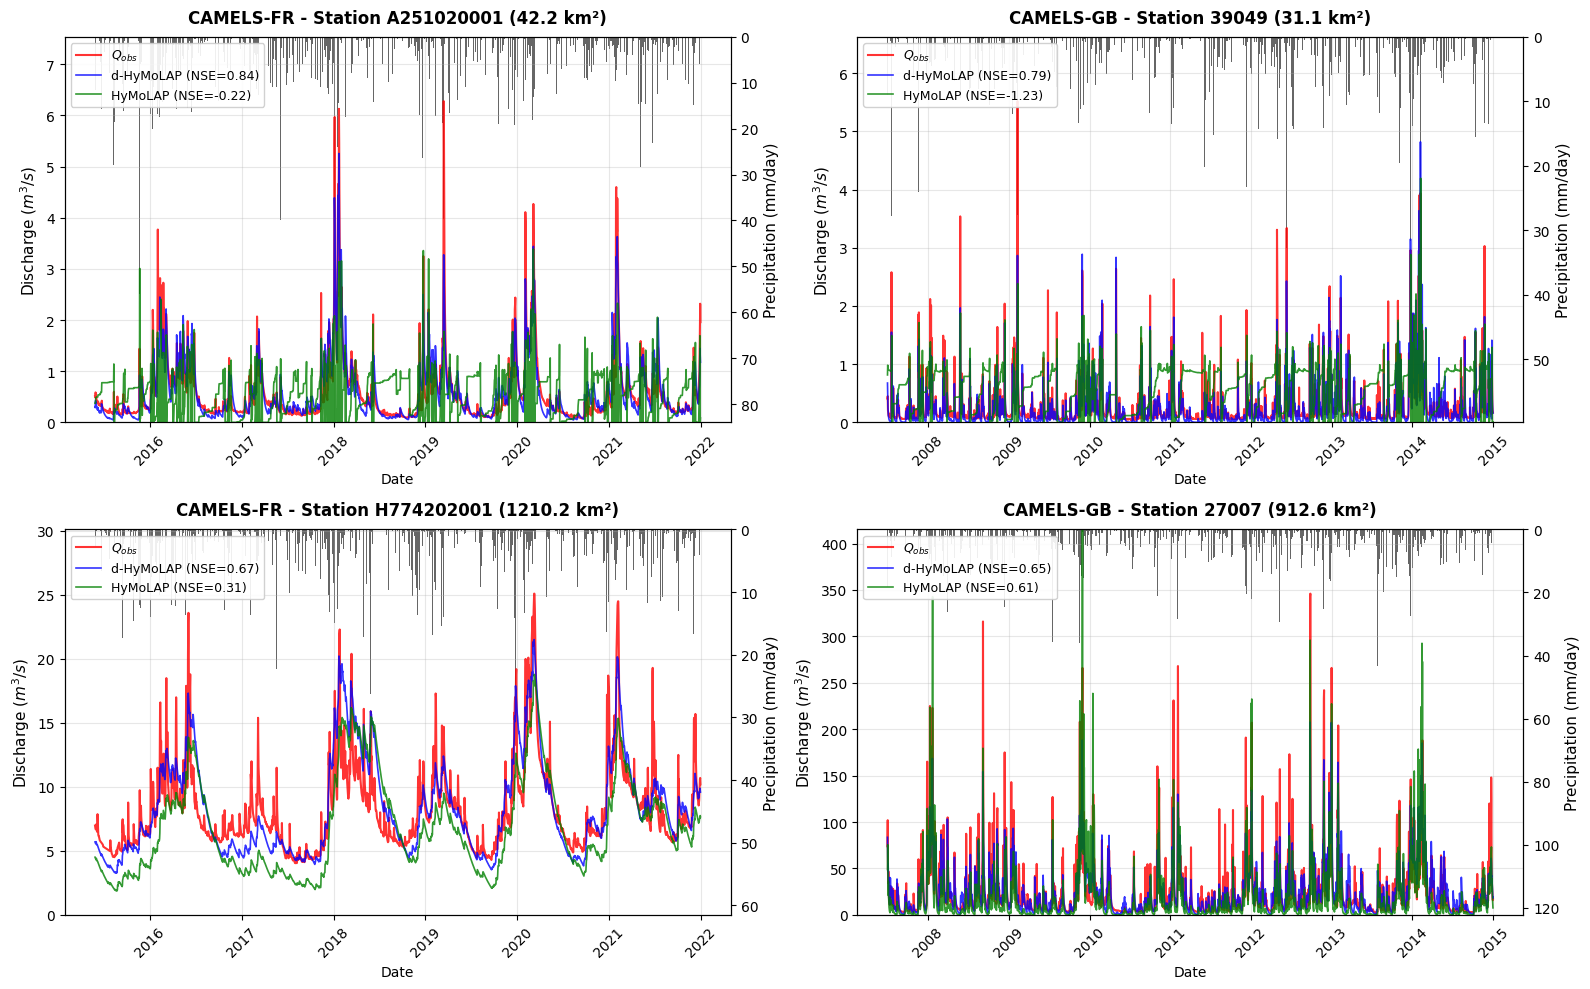


✓ Plot saved: quantile_catchments_comparison.pdf


In [ ]:
# ========================================================================
# STEP 6: PLOTTING - CORRECTED WITH STATION ID
# ========================================================================
print("\n" + "="*80)
print("STEP 6: GENERATING PLOTS")
print("="*80)

# Determine subplot layout based on number of quantiles
n_quantiles = len(QUANTILES)
n_plots = n_quantiles * 2  # FR and GB for each quantile

fig, axes = plt.subplots(2, n_quantiles, figsize=(8*n_quantiles, 10))
if n_quantiles == 1:
    axes = axes.reshape(2, 1)
axes = axes.flatten()

# Build plot order dynamically
plot_order = []
for q_key in [f'q{int(q*100):02d}' for q in QUANTILES]:
    plot_order.append(f'CAMELS_FR_{q_key}')
    plot_order.append(f'CAMELS_GB_{q_key}')

for idx, key in enumerate(plot_order):
    if key not in results:
        continue

    res = results[key]
    ax1 = axes[idx]

    # Extract data
    time = res['time']
    P = res['P']
    Q_obs = res['Q_obs']
    b1 = res['b1']

    Q_sim_d = res['models']['d-HyMoLAP']['Q_sim']
    Q_sim_h = res['models']['HyMoLAP']['Q_sim']

    NSE_val_d = res['models']['d-HyMoLAP']['NSE_val']
    NSE_val_h = res['models']['HyMoLAP']['NSE_val']

    # Plot discharge on LEFT axis (ax1)
    ax1.plot(time[b1:], Q_obs[b1:], 'r-', linewidth=1.5, label='$Q_{obs}$', alpha=0.8)
    ax1.plot(time[b1:], Q_sim_d[b1:], 'b-', linewidth=1.2,
             label=f'd-HyMoLAP (NSE={NSE_val_d:.2f})', alpha=0.8)
    ax1.plot(time[b1:], Q_sim_h[b1:], 'g-', linewidth=1.2,
             label=f'HyMoLAP (NSE={NSE_val_h:.2f})', alpha=0.8)
    ax1.set_ylabel(r'Discharge ($m^3/s$)', color='black', fontsize=11)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, np.nanmax(Q_obs[b1:]) * 1.2)
    ax1.set_xlabel('Date', fontsize=10)

    # Create secondary axis for precipitation on RIGHT (ax2)
    ax2 = ax1.twinx()

    # Plot precipitation as BAR on RIGHT axis (inverted)
    ax2.bar(time[b1:], P[b1:], color='black', alpha=0.6, width=1.0, edgecolor='none')
    ax2.set_ylabel('Precipitation (mm/day)', color='black', fontsize=11)
    ax2.tick_params(axis='y', labelcolor='black')

    # Set proper limits for precipitation
    P_max = np.nanmax(P[b1:])
    if P_max > 0:
        ax2.set_ylim(0, P_max * 1.5)  # Give more headroom
    else:
        ax2.set_ylim(0, 100)  # Default if no data

    ax2.invert_yaxis()  # Invert so precipitation goes downward

    # Title WITH STATION ID
    dataset = res['dataset']
    area = res['area']
    station_id = res['station_id']  # Extract station ID

    ax1.set_title(
        f"{dataset} - Station {station_id} ({area:.1f} km²)",
        fontsize=12,
        fontweight='bold',
        pad=10
    )

    # Legend on discharge axis (left)
    ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)

    # Grid on discharge axis
    ax1.grid(True, alpha=0.3, zorder=0)

    # X-axis formatting
    ax1.tick_params(axis='x', rotation=45)

    # Ensure discharge is on top
    ax1.set_zorder(ax2.get_zorder() + 1)
    ax1.patch.set_visible(False)  # Make ax1 background transparent

plt.tight_layout()
plt.savefig('quantile_catchments_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Plot saved: quantile_catchments_comparison.pdf")

In [ ]:
# ========================================================================
# STEP 7: SUMMARY
# ========================================================================
print("\n" + "="*80)
print("PIPELINE COMPLETE")
print("="*80)
print(f"\nQuantiles analyzed: {[f'{q*100:.0f}%' for q in QUANTILES]}")
print(f"Total catchments calibrated: {len(results)}")
print(f"Calibration ratio: {CALIB_RATIO*100:.0f}% train, {(1-CALIB_RATIO)*100:.0f}% validation")